In [1]:
from reinforce import ReinforceAgent, Categorical2D
from visualisation import draw_qap, draw_assignment_graph
from qap import GraphAssignmentProblem, AssignmentGraph
from torch_geometric.utils import from_networkx
import taskgenerators
import torch
from evaluate import random_assignment
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import networkx
import nn
from pathlib import Path
from ipywidgets import interact
import agent_configs

In [2]:
with open("testgraph.qap", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

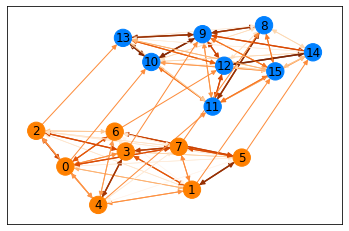

In [3]:
%matplotlib inline
draw_qap(qap, random_assignment(qap))

In [4]:
%matplotlib notebook
# enable interactive plots below

In [5]:
agents = []
path_prefix = Path("../runs/lptest_1/")
with open(path_prefix / "agenttype") as f:
    agent_type = f.read().strip()
agent_constructor = agent_configs.agents[agent_type]
for fname in sorted(path_prefix.glob("checkpoint_*.pth")):
    a = agent_constructor()
    a.load_checkpoint(fname)
    agents.append(a)

In [6]:
final_agent = agents[-1]
print(final_agent.solve_and_learn(qap))
for param in final_agent.policy_net.parameters():
    if param.grad is not None:
        print(torch.norm(param.grad), param.shape)

(9.7621125766285, array([7., 0., 3., 6., 5., 4., 1., 2.]))
tensor(0.0011) torch.Size([64, 64])
tensor(0.0001) torch.Size([64])
tensor(0.0004) torch.Size([64, 64])
tensor(5.4442e-05) torch.Size([64])
tensor(0.0004) torch.Size([64, 64])
tensor(2.2605e-05) torch.Size([64])
tensor(0.0016) torch.Size([1, 64])
tensor(1.7385e-05) torch.Size([1])


In [19]:
def plot_embedding(ax, embedding):
    with torch.no_grad():
        ax.clear()
        ax.set_ylim(-1,1)
        ax.bar(range(len(embedding)), embedding)

def show_embeddings(embeddings):
    fig = plt.figure()
    ax = fig.gca()
    interact(lambda i: plot_embedding(ax, embeddings[i-1]), i=(1,len(embeddings)))
    return fig
    
def show_embeddings_series(embeddings_series):
    fig = plt.figure()
    ax = fig.gca()
    interact(lambda i,j: plot_embedding(ax, embeddings_series[j-1][i-1]), 
             i=(1,len(embeddings_series[0])),
             j=(1,len(embeddings_series))
            )
    fig.show()

<IPython.core.display.Javascript object>


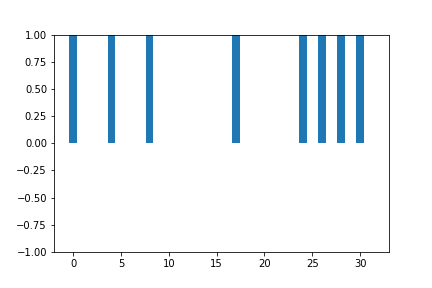

interactive(children=(IntSlider(value=4, description='i', max=8, min=1), IntSlider(value=11, description='j', …

In [20]:
%matplotlib notebook
# Node embeddings
start_graph_a_by_epoch = []
start_graph_b_by_epoch = []
start_net_states = []
for agent in agents:
    net = agent.policy_net
    start_graph_a_by_epoch.append(net.transform_initial_graph(qap.graph_source))
    start_graph_b_by_epoch.append(net.transform_initial_graph(qap.graph_target))
    start_net_states.append(net.initial_step(qap))
node_embedding_a_by_epoch = [data.x for data in start_graph_a_by_epoch]
node_embedding_b_by_epoch = [data.x for data in start_graph_b_by_epoch]
show_embeddings_series(node_embedding_a_by_epoch)

In [21]:
def plot_matrix(ax, matrix, **kwargs):
    with torch.no_grad():
        ax.imshow(matrix, **kwargs)

def show_matrix_series(series, **kwargs):
    fig = plt.figure()
    ax = fig.gca()
    interact(lambda i: plot_matrix(ax, series[i-1], **kwargs), 
             i=(1,len(series)),
            )
    fig.show()

<IPython.core.display.Javascript object>


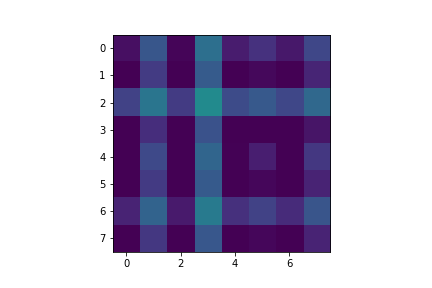

interactive(children=(IntSlider(value=11, description='i', max=21, min=1), Output()), _dom_classes=('widget-in…

In [22]:
# Probability matrices
all_nodes = list(qap.graph_source.nodes)
probs_by_epoch = torch.stack([
    agent.policy_net.compute_link_probabilities(
        start_net_states[i],
        all_nodes,
        all_nodes
    ) for i, agent in enumerate(agents)
])

fig = show_matrix_series(probs_by_epoch, vmin=torch.min(probs_by_epoch), vmax=torch.max(probs_by_epoch))

<IPython.core.display.Javascript object>


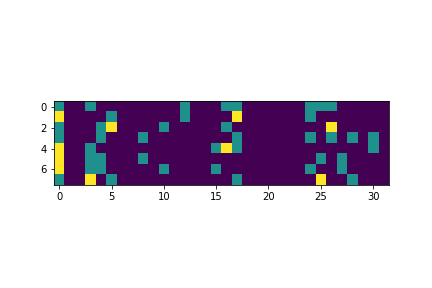

interactive(children=(IntSlider(value=11, description='i', max=21, min=1), Output()), _dom_classes=('widget-in…

In [23]:
show_matrix_series(node_embedding_a_by_epoch)

<IPython.core.display.Javascript object>


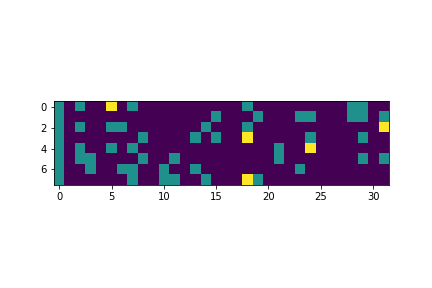

interactive(children=(IntSlider(value=11, description='i', max=21, min=1), Output()), _dom_classes=('widget-in…

In [24]:
show_matrix_series(node_embedding_b_by_epoch)

In [13]:
def print_parameter_gradients(x):
    agent.optimizer.zero_grad(set_to_none=True)
    x.backward(retain_graph=True)
    for param in agent.networks.parameters():
        if param.grad is not None:
            print(torch.norm(param.grad))

In [14]:
#print_parameter_gradients(probabilities[5,3])

In [15]:
#agent.link_freeze_net(torch.cat((embeddings_a[0], embeddings_b[1])))

In [16]:
baselines = [agent.baseline.mean() for agent in agents]

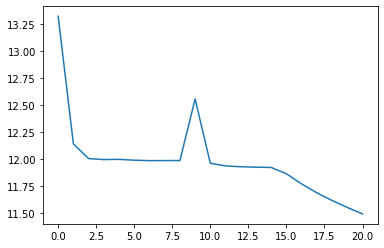

In [17]:
%matplotlib inline
plt.plot(baselines)
plt.show()